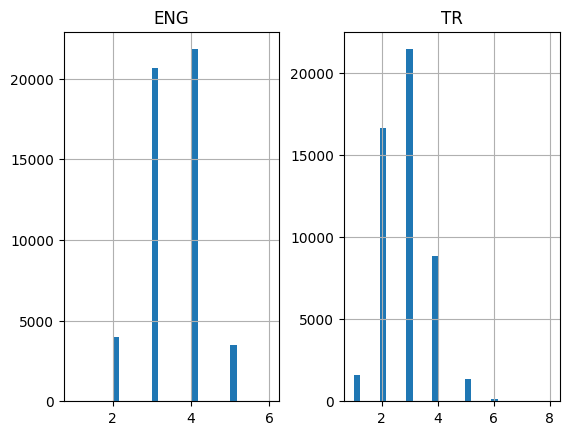

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string

# Function to read raw text file
def read_text(filename):
    with open(filename, mode='rt', encoding='utf-8') as file:
        return file.read()

# Split a text into sentence pairs
def to_sentence_pairs(text):
    lines = text.strip().split('\n')
    sentence_pairs = [line.split('\t') for line in lines]
    return np.array(sentence_pairs)[:50000]  # Limit to first 50,000 pairs for efficiency

# Remove punctuation and convert to lowercase
def preprocess_text(sentence_pairs):
    removal_trans = str.maketrans('', '', string.punctuation)
    for i in range(len(sentence_pairs)):
        sentence_pairs[i, 0] = sentence_pairs[i, 0].translate(removal_trans).lower()
        sentence_pairs[i, 1] = sentence_pairs[i, 1].translate(removal_trans).lower()
    return sentence_pairs

# Calculate and plot sentence lengths
def plot_sentence_lengths(sentence_pairs):
    eng_lengths = [len(sentence.split()) for sentence in sentence_pairs[:, 0]]
    other_lengths = [len(sentence.split()) for sentence in sentence_pairs[:, 1]]
    length_df = pd.DataFrame({'ENG': eng_lengths, 'TR': other_lengths})
    length_df.hist(bins=30)
    plt.show()

# Main execution
data = read_text('/home/azureuser/cloudfiles/code/Users/DANIEL.OBRIEN.2022/TR2EN.txt')
sentence_pairs = to_sentence_pairs(data)
preprocessed_pairs = preprocess_text(sentence_pairs)
plot_sentence_lengths(preprocessed_pairs)


In [3]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt

def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

eng_tokenizer = tokenization(sentence_pairs[:, 0])  # English sentences
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = 8

tr_tokenizer = tokenization(sentence_pairs[:, 1])  # Turkish sentences
tr_vocab_size = len(tr_tokenizer.word_index) + 1
tr_length = 8

# Example outputs
print('English Vocabulary Size:', eng_vocab_size)
print('Turkish Vocabulary Size:', tr_vocab_size)


2024-04-04 09:52:01.155630: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 09:52:04.241083: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-04 09:52:04.241106: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-04 09:52:09.685019: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

English Vocabulary Size: 6623
Turkish Vocabulary Size: 18445


In [4]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(sentence_pairs, test_size=0.2, random_state = 12)

In [5]:
# prepare training data
trainX = encode_sequences(tr_tokenizer, tr_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(tr_tokenizer, tr_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model
# model compilation
model = define_model(tr_vocab_size, eng_vocab_size, tr_length, eng_length, 512)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

2024-04-04 09:52:41.376978: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-04-04 09:52:41.377031: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (daniels-compute): /proc/driver/nvidia/version does not exist
2024-04-04 09:52:41.381650: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [1]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=5, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

NameError: name 'ModelCheckpoint' is not defined

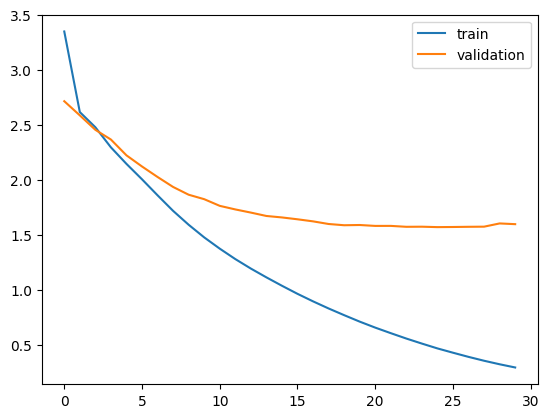

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [21]:
model = load_model('model.h1.24_jan_19')
preds = np.argmax(model.predict(testX), axis=1)

2024-04-03 10:52:44.690239: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-04-03 10:52:45.348236: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-04-03 10:52:45.465773: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-04-03 10:52:45.477540: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-04-03 10:52:45.499494: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _output_sh

313/313 [==============================] - 19s 56ms/step


In [23]:
import pandas as pd

def get_word(n, tokenizer):
    return tokenizer.index_word.get(n, '')

preds_text = []
for i in preds:
    temp = [get_word(token, eng_tokenizer) for token in i if token != 0]  # assuming 0 is used for padding
    preds_text.append(' '.join(temp).strip())

# Assuming `test` variable contains the actual translations for comparison
# Ensure `test` is appropriately defined; for example, it might be your test set's English sentences.
actual_texts = [' '.join([get_word(token, eng_tokenizer) for token in sent if token != 0]).strip() for sent in testX]

pred_df = pd.DataFrame({'actual': actual_texts, 'predicted': preds_text})

# Print 15 rows to inspect the results
print(pred_df.sample(15))

                             actual  \
1789                  a i hungry me   
4446                  tom along has   
7535                  tom good lost   
2228                                  
4161                      tom walks   
538         staggered pleased phone   
2111                            car   
1839                      busy need   
8401                   tom it turns   
8110                       a  tired   
9767  listed what i shouldve thirty   
4786                          funny   
2979   be requested transparent ill   
7083                           soil   
3109                                  

                                              predicted  
1789  im is i tom i i i tom i i i is i i tom i i is ...  
4446  im i tom i i i i tom i i i i i i tom i i i tom...  
7535  im is tom is is is is tom tom is is is is i to...  
2228  im i tom i tom i tom tom tom tom tom tom tom t...  
4161  im i tom i i i i tom i i i i i i i i i i tom t...  
538   im tom is i you tom t